# TL;DR - Jump to the end!

Feel free to scoll down to the last section of this notebook called "Monte Carlo Results".

# This Notebook is Interactive

You can just scroll through this notebook and read it as is. But this is also an interactive notebook, where you can change some of the source code to see what happens. To get ready to do that, pick "Run all" from the "Runtime" menu now (and accept the security warning). You only need to do this once each time you open this notebook. Then, go ahead and change the code as you see fit and press the triangle to the left of the code to run it.

# Net Present Value

This notebook shows how to compute the net present value for a product based on best estimates for a variety of inputs.

Formally, net present value (NPV) is the difference between the present value of cash inflows (like sales) and the present value of cash outflows (like development or cost of goods) over a period of time. NPV is used in capital budgeting and investment planning to analyze the profitability of a project. In general, projects with a positive NPV are worth undertaking, while those with a negative NPV are not.

Let's start by defining a present value function and a future value function.

In [3]:
def pv(future_value, rate, periods):
    return future_value / (1 + rate) ** periods

def fv(present_value, rate, periods):
    return present_value * (1 + rate) ** periods

Here we compute the future value of 100 at a rate of 3% per year after 5.4 years. Feel free to change the values and press the run button to the left of the code. Remember, if you see an error, make sure to pick "Run all" from the "Runtime" menu each time you open this notebook.

In [4]:
fv(100, 0.03, 5.4)

117.30621265790838

# Company Constants
Now let's define some global constants for our company that will be used to compute NPV.

In [5]:
# Company Constants (user input)
class CompanyConstants:
    def __init__(self,
                 market_return = 0.03,
                 yearly_development_fte_cost_pv = 50000,
                 inflation = 0.03,
                 sga_percentage = 0.30):
        
        # what we would expect to earn on an investment in a financial market with a similar risk
        self.market_return = market_return
        
        # how much it costs per person to run a product development team (in present dollars)
        self.yearly_development_fte_cost_pv = yearly_development_fte_cost_pv
        
        # how much costs increase each year
        self.inflation = inflation

        # the percentage of the selling price that is allocated to cover selling, general, and administrative expenses        
        self.sga_percentage = sga_percentage

company_constants = CompanyConstants()

So let's see how much it costs per person of a development team in three years from now.

In [6]:
fv(company_constants.yearly_development_fte_cost_pv, company_constants.inflation, 3)

54636.35

# Trianglular Ranges

Some of our parameters may have some uncertainty. For example, suppose we wanted to specify our unit cost not simply as 9000, but rather as a number that could be anywhere from 8000 to 12000, but most likely around 9000. We can define a triangular distribution of numbers, generate 1000 samples of this distribution, and plot what it looks like. Feel free to change the variables and run this again. Notice the three corresponding numbers in the brackets: "[8000, 9000, 12000]".

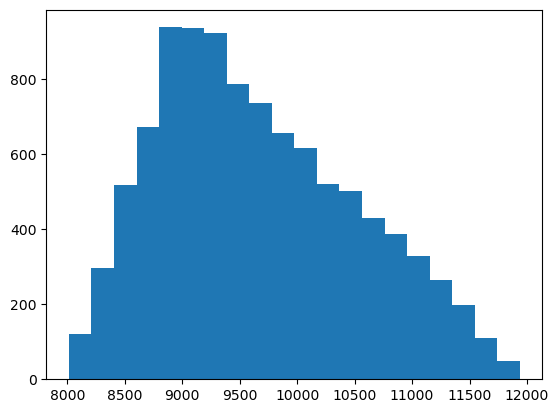

In [7]:
import numpy as np # linear algebra library
import matplotlib.pyplot as plt # plotting library

a = [8000, 9000, 12000]
sales = np.random.triangular(a[0], a[1], a[2], size=10000)
plt.hist(sales, bins=20)
plt.show()

# Product Variables Ranges

Now let's define the variables that describe our product. Some are single values, other have ranges, and some are dependent on others. As for ranges, they are specified by three numbers in brackets like this [3, 4, 5]. In this case, we expect the value to most likely be close to 4, with a range from 3 to 5.

In [8]:
# Return the value of a range, or a single value if it is not a range
def safe_index(range, i):
    if isinstance(range, (int, float)):
        return range
    return range[i]

# Product Variables Ranges (user input)
class ProductVariablesRanges:
    def __init__(self,
                 years_before_development = 1.5,
                 years_of_development_growth = 0,
                 years_of_development_maturity = [3, 4, 5],
                 years_of_development_decline = 0,
                 years_before_sales = 0,
                 years_of_sales_growth = 0,
                 years_of_sales_maturity = [8, 10, 12],
                 years_of_sales_decline = 0,
                 development_ftes = [4, 5, 6],
                 maintenance_ftes = [0, 0.5, 1],
                 unit_cost_pv = [8000, 9000, 12000],
                 unit_price_cost_factor = [1.9, 2.0, 2.1],
                 yearly_unit_sales_lowest_price = [110, 120, 150],
                 yearly_unit_sales_highest_price = [80, 90, 120]):
        
        # development years profile
        self.years_before_development = years_before_development
        self.years_of_development_growth = years_of_development_growth
        self.years_of_development_maturity = years_of_development_maturity
        self.years_of_development_decline = years_of_development_decline

        # sales years profile
        self.years_before_sales = years_before_sales
        self.years_of_sales_growth = years_of_sales_growth
        self.years_of_sales_maturity = years_of_sales_maturity
        self.years_of_sales_decline = years_of_sales_decline
        
        # the number of people (full time equivalents) on the development team
        self.development_ftes = development_ftes

        # the number of people that need to keep working on the product after development
        self.maintenance_ftes = maintenance_ftes
        
        # the cost to manufacture one unit of the product (in present dollars)
        self.unit_cost_pv = unit_cost_pv
        
        # the selling price cost factors to compute the price of the product (in present dollars)
        self.unit_price_cost_factor = unit_price_cost_factor

        # the number of units that are expected to be sold per year
        self.yearly_unit_sales_lowest_price = yearly_unit_sales_lowest_price
        self.yearly_unit_sales_highest_price = yearly_unit_sales_highest_price

    def lowest_price(self):
        return safe_index(self.unit_cost_pv, 0) * safe_index(self.unit_price_cost_factor, 0)
    
    def highest_price(self):
        return safe_index(self.unit_cost_pv, 2) * safe_index(self.unit_price_cost_factor, 2)

product_variables_ranges = ProductVariablesRanges()

This is how we can view the range of unit cost.

In [9]:
product_variables_ranges.unit_cost_pv

[8000, 9000, 12000]

We also added some functions to compute the range of the lowest and highest price.

In [10]:
print(product_variables_ranges.lowest_price())
print(product_variables_ranges.highest_price())

15200.0
25200.0


# Triangle Ranges (again)

Here is a more complex triangle random number generator. It takes a flag ("expected") indicating whether or not it should simply return the expected value instead of a random value in the range. That will come in handy later. Also, if you provide this function with a single number, then it will just return that single number.

In [11]:
# Return a single random number, given a low, expected, and high range, using a triangular distribution
# Just return the expected number if requested, or if the range is invalid
def triangle(a, just_expected = False):

    # if a is a single number, return it
    if isinstance(a, (int, float)):
        return a

    # if the range is invalid, return the likely (middle) value
    if(a[0] > a[1] or a[1] > a[2] or a[0] >= a[2]):
        return a[1]
    
    # if requested, just return the likely (middle) value
    if (just_expected):
        return a[1]
    
    # return a random number, given a low, likely, and high range, using a triangular distribution
    return np.random.triangular(a[0], a[1], a[2])

This is how we can use the triangle function to generate a random number for unit cost, or just the expected cost. Feel free to run this code multiple times.

In [12]:
print(triangle(100))
print(triangle([100, 200, 300]))
print(triangle([100, 200, 300], True))
print(triangle(product_variables_ranges.unit_cost_pv))
print(triangle(product_variables_ranges.unit_cost_pv, True))

100
241.34777385036062
200
8892.579078702518
9000


So let's plot the range of unit costs using the random number generator.

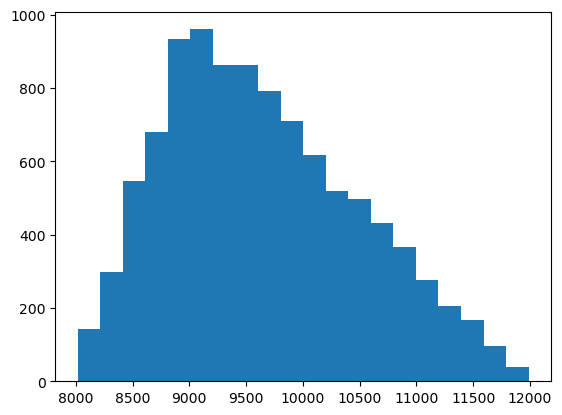

In [13]:
plt.hist([triangle(product_variables_ranges.unit_cost_pv) for _ in range(10000)], bins=20)
plt.show()

Let's do it again, but with setting just_expected to True.

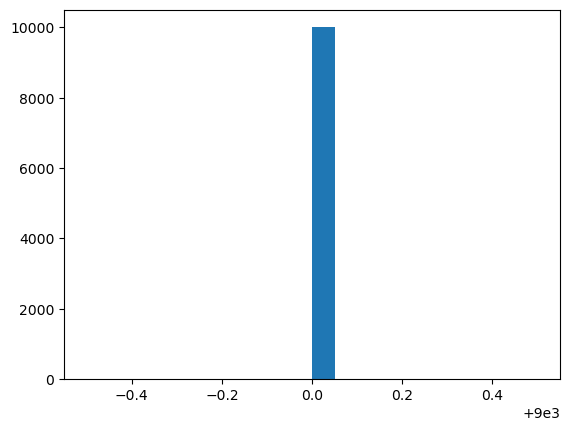

In [14]:
plt.hist([triangle(product_variables_ranges.unit_cost_pv, True) for _ in range(10000)], bins=20)
plt.show()

# Tornado Chart

A tornado chart is a chart that shows the range of NPV due to a single product variable. It is a stacked horizontal bar chart with the variable that creates the most variance of NPV at the top, and the least at the bottom. To create a tornado chart, we need the random number generator to vary just one product variable at a time (and use the expected value for all the rest). Here are the variables for which we want to compute a range and then place in our tornado chart.

In [15]:
from enum import Enum

# Used to lock in all but one variable when computing a tornado sensitivity analysis
class Tornado(Enum):
    OFF = 0
    Dev_Ftes = 1
    Dev_Years = 2
    Maint_Ftes = 3
    Sales_Years = 4
    Unit_Cost = 5
    Margin = 6
    Yearly_Sales = 7

Here is an example of what the tornado chart will look like.

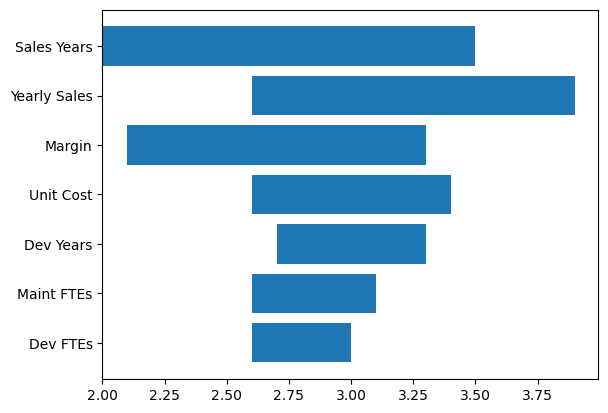

In [16]:
names = ['Dev FTEs', 'Maint FTEs', 'Dev Years', 'Unit Cost', 'Margin', 'Yearly Sales', 'Sales Years']
ranges = [0.4, 0.5, 0.6, 0.8, 1.2, 1.3, 1.5]
min_values = [2.6, 2.6, 2.7, 2.6, 2.1, 2.6, 2.0]
plt.barh(names, ranges, left=min_values)
plt.show()

# Product Variables Snapshot

This creates a snapshot of all the product variables, given their ranges. That is, for every range in product_variables_ranges, we will generate a single random variable (with the same name). If a tornado sensitivity analysis is being computed then we will only generate a single random variable to just the range specified, and use the most likely value for the rest of the ranges. The results are returned in a new variable we will call product_variable_snapshot, and the original product_variables_ranges is unchanged.

Notice that unit_price_pv is not independatly random, but rather depends on unit_cost_pv and the unit_price_cost_factor.

Also, the yearly_unit_sales is a function of price and an interpolation of the two extreeme estimates of yearly_unit_sales_lowest_price and yearly_unit_sales_highest_price.

In [17]:
# Create a snapshot of the product variables with random values
class ProductVariablesSnapshot:
    def __init__(self, product_variables_ranges, tornado = Tornado.OFF):
        
        # convert various ranges to actual values using a triangular distribution (or use the likely value if a tornado sensitivity analysis is being performed)
        self.development_ftes = triangle(product_variables_ranges.development_ftes, tornado != Tornado.OFF and tornado != Tornado.Dev_Ftes)
        self.years_before_development = triangle(product_variables_ranges.years_before_development)
        self.years_of_development_growth = triangle(product_variables_ranges.years_of_development_growth)
        self.years_of_development_maturity = triangle(product_variables_ranges.years_of_development_maturity, tornado != Tornado.OFF and tornado != Tornado.Dev_Years)
        self.years_of_development_decline = triangle(product_variables_ranges.years_of_development_decline)
        self.maintenance_ftes = triangle(product_variables_ranges.maintenance_ftes, tornado != Tornado.OFF and tornado != Tornado.Maint_Ftes)
        self.years_before_sales = triangle(product_variables_ranges.years_before_sales)
        self.years_of_sales_growth = triangle(product_variables_ranges.years_of_sales_growth)
        self.years_of_sales_maturity = triangle(product_variables_ranges.years_of_sales_maturity, tornado != Tornado.OFF and tornado != Tornado.Sales_Years)
        self.years_of_sales_decline = triangle(product_variables_ranges.years_of_sales_decline)
        self.unit_cost_pv = triangle(product_variables_ranges.unit_cost_pv, tornado != Tornado.OFF and tornado != Tornado.Unit_Cost)
        self.unit_price_cost_factor = triangle(product_variables_ranges.unit_price_cost_factor, tornado != Tornado.OFF and tornado != Tornado.Margin)

        # some product variables are dependent on others, so we need to compute them

        # compute the unit price
        self.unit_price_pv = self.unit_cost_pv * self.unit_price_cost_factor

        # interpolate the yearly unit sales range as a function of the unit price
        price_range = np.array([product_variables_ranges.lowest_price(), product_variables_ranges.highest_price()])
        yearly_unit_sales_range = [0, 0, 0]
        for i in range(3):
            sales_range_i = np.array([safe_index(product_variables_ranges.yearly_unit_sales_lowest_price, i), safe_index(product_variables_ranges.yearly_unit_sales_highest_price, i)])            
            yearly_unit_sales_range[i] = np.interp(self.unit_price_pv, price_range, sales_range_i)
        
        # convert the sales range to an actual value using a triangular distribution
        self.yearly_unit_sales = triangle(yearly_unit_sales_range, tornado != Tornado.OFF and tornado != Tornado.Yearly_Sales)

        # precalculate the total remaining years
        self.total_remaining_years = self.years_before_development + self.years_of_development_growth + self.years_of_development_maturity + self.years_of_development_decline + self.years_before_sales + self.years_of_sales_growth + self.years_of_sales_maturity + self.years_of_sales_decline

    # compute the development full time equivalents for a given month
    def development_ftes_this_month(self, month):
        if month < self.years_before_development * 12:
            return 0
        month -= self.years_before_development * 12
        if month < self.years_of_development_growth * 12:
            return self.development_ftes * month / (self.years_of_development_growth * 12)
        month -= self.years_of_development_growth * 12
        if month < self.years_of_development_maturity * 12:
            return self.development_ftes
        month -= self.years_of_development_maturity * 12
        if month < self.years_of_development_decline * 12:
            return self.development_ftes * (1 - month / (self.years_of_development_decline * 12))
        return self.maintenance_ftes
    
    # compute the unit sales for a given month
    def unit_sales_this_month(self, month):
        month -= self.years_before_development * 12
        month -= self.years_of_development_growth * 12
        month -= self.years_of_development_maturity * 12
        month -= self.years_of_development_decline * 12
        if month < self.years_before_sales * 12:
            return 0
        month -= self.years_before_sales * 12
        if month < self.years_of_sales_growth * 12:
            return self.yearly_unit_sales * month / (self.years_of_sales_growth * 12) / 12
        month -= self.years_of_sales_growth * 12
        if month < self.years_of_sales_maturity * 12:
            return self.yearly_unit_sales / 12
        month -= self.years_of_sales_maturity * 12
        if month < self.years_of_sales_decline * 12:
            return self.yearly_unit_sales * (1 - month / (self.years_of_sales_decline * 12)) / 12
        return 0
    
    def __str__(self):
        return (f"development_ftes={self.development_ftes},\n"
            f"years_before_development={self.years_before_development},\n"
            f"years_of_development_growth={self.years_of_development_growth},\n"
            f"years_of_development_maturity={self.years_of_development_maturity},\n"
            f"years_of_development_decline={self.years_of_development_decline},\n"
            f"maintenance_ftes={self.maintenance_ftes},\n"
            f"years_before_sales={self.years_before_sales},\n"
            f"years_of_sales_growth={self.years_of_sales_growth},\n"
            f"years_of_sales_maturity={self.years_of_sales_maturity},\n"
            f"years_of_sales_decline={self.years_of_sales_decline},\n"
            f"unit_cost_pv={self.unit_cost_pv},\n"
            f"unit_price_cost_factor={self.unit_price_cost_factor},\n"
            f"unit_price_pv={self.unit_price_pv},\n"
            f"yearly_unit_sales={self.yearly_unit_sales},\n"
            f"total_remaining_years={self.total_remaining_years}")

Here is what the snapshot looks like, allowing all ranges to be computed with the random number generator. Please execute the cell below multiple times to see various scenarios.

In [18]:
print(ProductVariablesSnapshot(product_variables_ranges))

development_ftes=4.573639880382496,
years_before_development=1.5,
years_of_development_growth=0,
years_of_development_maturity=3.2964672152772683,
years_of_development_decline=0,
maintenance_ftes=0.16726616804402283,
years_before_sales=0,
years_of_sales_growth=0,
years_of_sales_maturity=10.145320985226615,
years_of_sales_decline=0,
unit_cost_pv=9170.433606717696,
unit_price_cost_factor=1.9671531359645664,
unit_price_pv=18039.647227609563,
yearly_unit_sales=105.38548421974541,
total_remaining_years=14.941788200503883


Here is what the snapshot of product variable looks like, allowing only yearly sales to change.  You can execute the cell below multiple times to see various scenarios.

In [19]:
product_variables_snapshot = ProductVariablesSnapshot(product_variables_ranges, Tornado.Yearly_Sales)
print(product_variables_snapshot)

development_ftes=5,
years_before_development=1.5,
years_of_development_growth=0,
years_of_development_maturity=4,
years_of_development_decline=0,
maintenance_ftes=0.5,
years_before_sales=0,
years_of_sales_growth=0,
years_of_sales_maturity=10,
years_of_sales_decline=0,
unit_cost_pv=9000,
unit_price_cost_factor=2.0,
unit_price_pv=18000.0,
yearly_unit_sales=112.84590200481438,
total_remaining_years=15.5


# NPV Calculation Result

Given the company_constants and the product_variable_snapshot, we can compute the NPV. We do this by calculating sales, cost_of_goods, sga, and development_costs. Before looking at the code that computes the NPV, let's look at what the NPV calculator will return.

In [20]:
# The result of a single NPV calculation
class NpvCalculationResult:
    def __init__(self):
        self.development_cost = 0
        self.sales = 0
        self.cost_of_goods = 0
        self.sga = 0
        self.unit_sales = 0
        self.total_remaining_years = 0
        self.investment_before_revenue = 0
        self.years_until_revenue = 0
        self.years_until_break_even = 0

    def npv(self):
        return self.sales - self.cost_of_goods - self.sga - self.development_cost

    def roi(self):
        if( self.development_cost == 0):
            return 0
        return self.npv() / self.development_cost

    def annualized_roi(self, years):
        if( years == 0):
            return 0
        return (1 + self.roi()) ** (1 / years) - 1
    
    def __str__(self):
        return (f"development_cost={self.development_cost},\n"
            f"sales={self.sales},\n"
            f"cost_of_goods={self.cost_of_goods},\n"
            f"sga={self.sga},\n"
            f"unit_sales={self.unit_sales},\n"
            f"total_remaining_years={self.total_remaining_years},\n"
            f"investment_before_revenue={self.investment_before_revenue},\n"
            f"years_until_revenue={self.years_until_revenue},\n"
            f"years_until_break_even={self.years_until_break_even},\n"
            f"npv={self.npv()},\n"
            f"roi={self.roi()}")

# NPV Calculator

This is the actual calculation code. Notice it breaks down the problem by iterating through each month of the project lifetime. Another takeaway is that we are using inflation to predict future dollars, but the market_return to determine the present value of those future dollars.

In [21]:
# Calculate the NPV of a product
def calculate_npv(product_variables_snapshot, company_constants):

    # this is what we will calculate and return 
    result = NpvCalculationResult()

    # loop through all the months
    for month in range(round(product_variables_snapshot.years_before_development * 12), round(product_variables_snapshot.total_remaining_years * 12) + 1):
    
        # compute the development_ftes for this month
        development_ftes = product_variables_snapshot.development_ftes_this_month(month)

        # compute the unit sales for this month
        unit_sales = product_variables_snapshot.unit_sales_this_month(month)

        # compute the future value of the cost of development, unit cost, and unit price for this month
        monthly_development_cost_fte_fv = fv(company_constants.yearly_development_fte_cost_pv / 12, company_constants.inflation / 12, month)
        unit_cost_fv = fv(product_variables_snapshot.unit_cost_pv, company_constants.inflation / 12, month)
        unit_price_fv = fv(product_variables_snapshot.unit_price_pv, company_constants.inflation / 12, month)

        # compute the selling, general, and administrative expenses per unit
        sga_fv = unit_price_fv * company_constants.sga_percentage

        # add the cost of development in present value terms
        result.development_cost += pv(development_ftes * monthly_development_cost_fte_fv, company_constants.market_return / 12, month)
        result.unit_sales += unit_sales
        result.sales += pv(unit_sales * unit_price_fv, company_constants.market_return / 12, month)
        result.cost_of_goods += pv(unit_sales * unit_cost_fv, company_constants.market_return / 12, month)
        result.sga += pv(unit_sales * sga_fv, company_constants.market_return / 12, month)

        # if we haven't started earning revenue yet, and we just did, record the year
        if( result.years_until_revenue == 0 and unit_sales > 0):
            result.years_until_revenue = month / 12
            result.investment_before_revenue = result.development_cost

        # if we haven't broken even yet, and we just did, record the year
        if( result.years_until_break_even == 0 and result.npv() >= 0):
            result.years_until_break_even = month / 12

    # handy for the result
    result.total_remaining_years = product_variables_snapshot.total_remaining_years

    return result

Let's compute the NPV for our variables.

In [22]:
result = calculate_npv(product_variables_snapshot, company_constants)
print(result)

development_cost=1252083.3333333274,
sales=20312262.360866554,
cost_of_goods=10156131.180433277,
sga=6093678.708259986,
unit_sales=1128.459020048146,
total_remaining_years=15.5,
investment_before_revenue=1002083.3333333341,
years_until_revenue=5.5,
years_until_break_even=8.083333333333334,
npv=2810369.138839964,
roi=2.2445543870934923


Let's compute NPV for several scenarios. We call these "Simulations". Each time through the loop, we create another snapshot, which generates new random variables.

In [23]:
for _ in range(5):
    product_variables_snapshot = ProductVariablesSnapshot(product_variables_ranges)
    result = calculate_npv(product_variables_snapshot, company_constants)
    print(result.npv())

3092951.171705667
3259147.333930337
3238999.273517821
2800164.475838183
3294797.047951296


# Storing and Plotting Multiple Simulations

Here is a place we can store some data from each NPV calculation. The add function takes an NPV calculation result and picks off some things we want to save.

In [24]:
# Track all the results of multiple calculations
class SimulationTracker:
    def __init__(self):
        self.npvs_millions = []
        self.development_costs_millions = []
        self.annualized_rois_percentage = []
        self.unit_sales_thousands = []
        self.sales_millions = []
        self.years = []
        self.investment_before_revenue = []
        self.years_until_revenue = []
        self.years_until_break_even = []
    
    def add(self, result):
        self.npvs_millions.append(result.npv() / 1000000)
        self.development_costs_millions.append(result.development_cost / 1000000)
        self.annualized_rois_percentage.append(result.annualized_roi(result.total_remaining_years) * 100)
        self.unit_sales_thousands.append(result.unit_sales / 1000)
        self.sales_millions.append(result.sales / 1000000)
        self.years.append(result.total_remaining_years)
        self.investment_before_revenue.append(result.investment_before_revenue / 1000000)
        self.years_until_revenue.append(result.years_until_revenue)
        self.years_until_break_even.append(result.years_until_break_even)


Now let's keep stats of 1000 simulations.

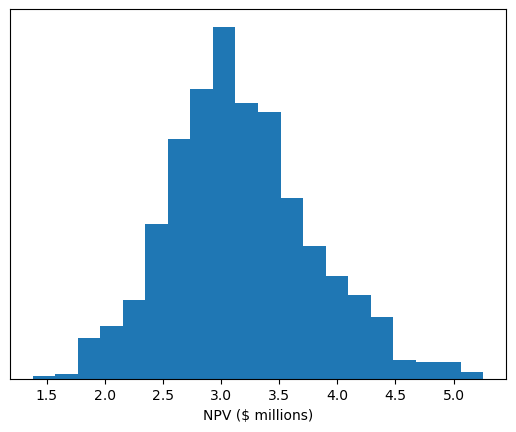

In [25]:
simulation_tracker = SimulationTracker()

for _ in range(1000):
    product_variables_snapshot = ProductVariablesSnapshot(product_variables_ranges)
    result = calculate_npv(product_variables_snapshot, company_constants)
    simulation_tracker.add(result)

plt.hist(simulation_tracker.npvs_millions, bins=20)
plt.xlabel('NPV ($ millions)', fontsize=10)
plt.yticks([])
plt.show()

# Putting it all together

Now let's put it all together for a full analysis. First, we also need a place to store tornado simulations.

In [26]:
class TornadoTracker:
    def __init__(self, tornado, name):
        self.tornado = tornado
        self.name = name
        self.min_value = float('inf')
        self.max_value = float('-inf')

    def add(self, value):
        if value < self.min_value:
            self.min_value = value
        if value > self.max_value:
            self.max_value = value
    
    def range(self):
        return self.max_value - self.min_value

Here is the final analysis code. Notice we start with gathering the company_constants and the product_variable_ranges. We then create a place to store each simulation and seven different tornado sensitivity analysis results.

We define a function called analyze that runs a bunch of simulations while varying all the ranges, and then just one range at a time for seven ranges.

Finally we define a function to plot the results.

The concept of running a lot of simulations and plotting the results is called a "Monte Carlo Analysis"

In [27]:
class MonteCarloAnalyzer:
    def __init__(self, company_constants, product_variables_ranges):
        self.company_constants = company_constants
        self.product_variables_ranges = product_variables_ranges
        self.simulation_tracker = SimulationTracker()
        self.tornado_trackers = []
        self.tornado_trackers.append(TornadoTracker(Tornado.Dev_Ftes, 'Dev FTEs'))
        self.tornado_trackers.append(TornadoTracker(Tornado.Dev_Years, 'Dev Years'))
        self.tornado_trackers.append(TornadoTracker(Tornado.Maint_Ftes, 'Maint FTEs'))
        self.tornado_trackers.append(TornadoTracker(Tornado.Sales_Years, 'Sales Years'))
        self.tornado_trackers.append(TornadoTracker(Tornado.Unit_Cost, 'Unit Cost'))
        self.tornado_trackers.append(TornadoTracker(Tornado.Margin, 'Margin'))
        self.tornado_trackers.append(TornadoTracker(Tornado.Yearly_Sales, 'Yearly Sales'))

    def analyze(self):
        # compute the monte carlo analysis
        for i in range(2000):
            product_variables_snapshot = ProductVariablesSnapshot(self.product_variables_ranges)
            result = calculate_npv(product_variables_snapshot, self.company_constants)
            self.simulation_tracker.add(result)

        # compute the tornado analysis
        for i in range(100):    
            for tornado_tracker in self.tornado_trackers:
                product_variables_snapshot = ProductVariablesSnapshot(self.product_variables_ranges, tornado_tracker.tornado)
                result = calculate_npv(product_variables_snapshot, self.company_constants)
                tornado_tracker.add(result.npv() / 1000000)

        # Sort the tornado trackers by range
        self.tornado_trackers.sort(key=lambda x: x.range())
    
    # create a histogram
    def create_histogram(self, data, bins, xlabel, subplot_position, rows, cols):
        plt.subplot(rows, cols, subplot_position)
        plt.hist(data, bins=bins, edgecolor='black')
        plt.yticks([])
        plt.xlabel(xlabel, fontsize=10)

    # create a tornado plot
    def create_tornado_plot(self, names, ranges, min_values, xlabel, subplot_position, rows, cols):
        plt.subplot(rows, cols, subplot_position)
        plt.barh(names, ranges, left=min_values)
        plt.xlabel(xlabel)

    # plot the results
    def plot(self, file_path = ""):
        rows = 3
        cols = 3
        plt.figure(figsize=(10, 5))

        self.create_histogram(self.simulation_tracker.unit_sales_thousands, 20, 'Sales (units/1000)', 1, rows, cols)
        self.create_histogram(self.simulation_tracker.sales_millions, 20, 'Sales ($ millions)', 2, rows, cols)
        self.create_histogram(self.simulation_tracker.development_costs_millions, 20, 'Development ($ millions)', 3, rows, cols)
        self.create_histogram(self.simulation_tracker.npvs_millions, 20, 'NPV ($ millions)', 4, rows, cols)
        self.create_histogram(self.simulation_tracker.annualized_rois_percentage, 20, 'Annualized ROI (%)', 5, rows, cols)
        # self.create_histogram(self.years, 30, 'Product Years', 6, rows, cols)
        self.create_histogram(self.simulation_tracker.investment_before_revenue, 20, 'Investment before Revenue ($ millions)', 6, rows, cols)
        self.create_histogram(self.simulation_tracker.years_until_revenue, 10, 'Years until Revenue', 7, rows, cols)
        self.create_histogram(self.simulation_tracker.years_until_break_even, 10, 'Years until Break Even', 8, rows, cols)

        tornado_names = [tornado_tracker.name for tornado_tracker in self.tornado_trackers]
        tornado_ranges = [tornado_tracker.range() for tornado_tracker in self.tornado_trackers]
        tornado_min_values = [tornado_tracker.min_value for tornado_tracker in self.tornado_trackers]
        self.create_tornado_plot(tornado_names, tornado_ranges, tornado_min_values, 'NPV Sensitivity ($ millions)', 9, rows, cols)

        plt.tight_layout()
        if( file_path != ""):
            plt.savefig(file_path)
        else:
            plt.show()
        plt.close()

# Monte Carlo Results

Below you will find some code and a plot.

The code defines company variables like the cost of a full-time-equivalent engineer in the product development department. In this case 50000. The code also defines product variables like unit cost. Unit cost is given as a range of three number, the lowest, the most likely, and the highest unit cost. In this case, we expect the unit cost to be 9000, but range from 8000 to 12000.

One of the plots below shows the expected NPV of moving forward with the product as a range (histogram). In this case the NPV ranges from about 2 to 5 million, with 3 million being the most likely.

The strange looking plot shows which ranges are causing the most uncertainty in NPV. In this case, Sales Years is the biggest driver of uncertainty.

The plot can be updated when you make changes to the code. To get ready to do that, pick "Run all" from the "Runtime" menu now (and accept the security warning). You only need to do this once each time you open this notebook.

Then, go ahead and change the code as you see fit and press the triangle to the left of the code to run it.

For example, if you want to increase the expected inflation to 5%, set company_constants.inflation = 0.05, and then press the triangle to the left of the code to see the new plots.

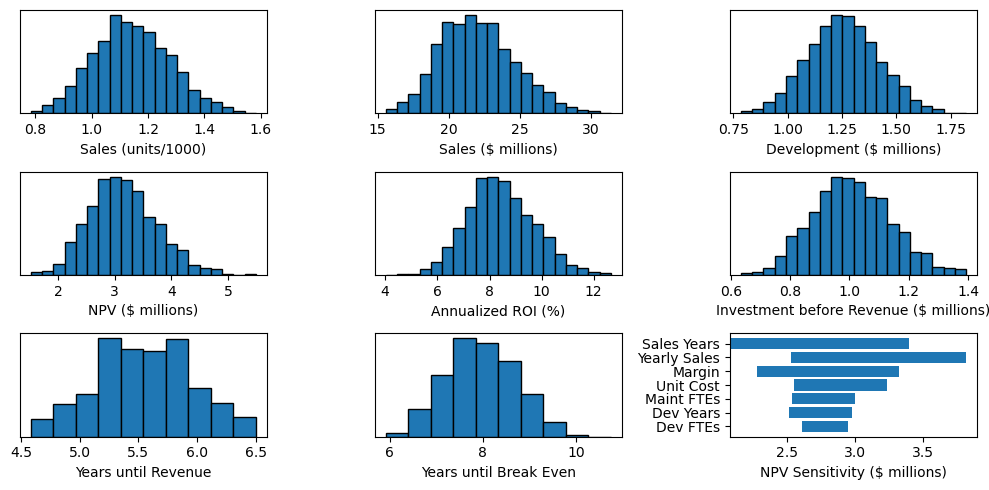

In [28]:
company_constants.market_return = 0.03
company_constants.yearly_development_fte_cost_pv = 50000
company_constants.inflation = 0.03
company_constants.sga_percentage = 0.30

product_variables_ranges.years_before_development = 1.5
product_variables_ranges.years_of_development_growth = 0
product_variables_ranges.years_of_development_maturity = [3, 4, 5]
product_variables_ranges.years_of_development_decline = 0
product_variables_ranges.years_before_sales = 0
product_variables_ranges.years_of_sales_growth = 0
product_variables_ranges.years_of_sales_maturity = [8, 10, 12]
product_variables_ranges.years_of_sales_decline = 0
product_variables_ranges.development_ftes = [4, 5, 6]
product_variables_ranges.maintenance_ftes = [0, 0.5, 1]
product_variables_ranges.unit_cost_pv=[8000, 9000, 12000]
product_variables_ranges.unit_price_cost_factor = [1.9, 2.0, 2.1]
product_variables_ranges.yearly_unit_sales_lowest_price = [110, 120, 150]
product_variables_ranges.yearly_unit_sales_highest_price = [80, 90, 120]

monte_carlo = MonteCarloAnalyzer(company_constants, product_variables_ranges)
monte_carlo.analyze()
monte_carlo.plot()